In [1]:
# Import simulation packages
import xtrack as xt
import xpart as xp
import xobjects as xo
from cpymad.madx import Madx

# Import scientific packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scipy as sp
from scipy import constants
import scipy.signal
from scipy.signal import chirp, spectrogram

# Import custom signal generator
from signal_gen import generate_afg_chirp, kick_angle

# Import timing packages
from tqdm import tqdm
import time as timing

# Import standard packages
import os
import json
import sys
import pickle as pkl
from collections import Counter

import requests


/Users/eliottjohnson/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Conversion factors
RAD_TO_MRAD = 1000
M_TO_MM = 1000
MS_TO_S = 1e-3

# Beam parameters
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 2e-6
eyn = 2e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 5.392 # beam momentum (GeV/c)
momentum = p # beam momentum (GeV/c)
Brho = p*3.3356

DPP_FACTOR = 1.54e-3
# DPP_FACTOR = 0*1.54e-3

PARENT_DIR = "."
os.makedirs(PARENT_DIR, exist_ok=True)

# Use the PS lattice as of 24 may
LATTICE = "ps_24May.seq"

print(f"Parent Directory: {PARENT_DIR}")
mad = Madx(stdout=False)

# Import PS lattice
# mad.call(LATTICE)

mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/ps_mu.seq").text)
mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/ps_ss.seq").text)
mad.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-ps/-/raw/2022/scenarios/east/4_slow_extraction/ps_se_east.str").text)

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey,
    charge = 1
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")

# turn off 23 for ions
mad.input("kPEBSW23 := 0;")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')

def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    mad.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
    ptc_create_universe;
    ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
    IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
    }
    ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
    }
    ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    mad.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    mad.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    mad.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    mad.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    mad.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    mad.use(sequence="PS")
    twiss_tune_matching = mad.twiss().dframe() # Needed to refresh the tune values
    mad.input('qx = table(SUMM, Q1);')
    mad.input('qy = table(SUMM, Q2);')
    mad.input('qxp = table(SUMM, DQ1);')
    mad.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": mad.globals["qx"], "Qy": mad.globals["qy"], "Qxp": mad.globals["qxp"], "Qyp": mad.globals["qyp"]}
    pfw_dict = {"k1prpfwf": mad.globals["k1prpfwf"], "k1prpfwd": mad.globals["k1prpfwd"], "k2prpfwf": mad.globals["k2prpfwf"], "k2prpfwd": mad.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")
    
    return pfw_dict, tune_info_dict

# Data taken from Qmeter
QX_TARGET = 0.325
QPX_TARGET = -0.5

QY_TARGET = 0.256
QPY_TARGET = -0.242

# Match tune using PFWs
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=QX_TARGET,Qxp=QPX_TARGET,Qy=QY_TARGET,Qyp=QPY_TARGET, p=p, ex=ex, ey=ey)

mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")

# Makethin with 4 slices
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')
twiss_after_makethin = mad.twiss().dframe()

print("> Import Complete, MAD-X is ready to go!")

Parent Directory: .
H-tune: 6.325, H-Chroma: -0.508
V-Tune: 6.256, V-Chroma: -0.245

PFW settings: 
  k1prpfwf: 4.2e-05
  k1prpfwd: -0.000131
  k2prpfwf: 0.006612
  k2prpfwd: -0.017293
> Import Complete, MAD-X is ready to go!


In [3]:
Qx = tune_info_on_resonance['Qx']
Qxp = tune_info_on_resonance['Qxp']
print(f"Qx = {Qx}, Qxp = {Qxp}")

Qx = 6.324993445183833, Qxp = -0.5077091944217004


In [7]:
# context
ctx = xo.ContextCpu()

# Convert Line to Xsuite
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(), allow_thick=True
    )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

# Calculate Frev
line.build_tracker(_context=ctx)
twiss = line.twiss(method='4d')
trev = twiss['T_rev0']
frev = 1/trev
line.unfreeze()
print(f"frev = {frev}")

Converting sequence "ps": 99%     
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
frev = 412657.224132077


Text(0, 0.5, 'x [m]')

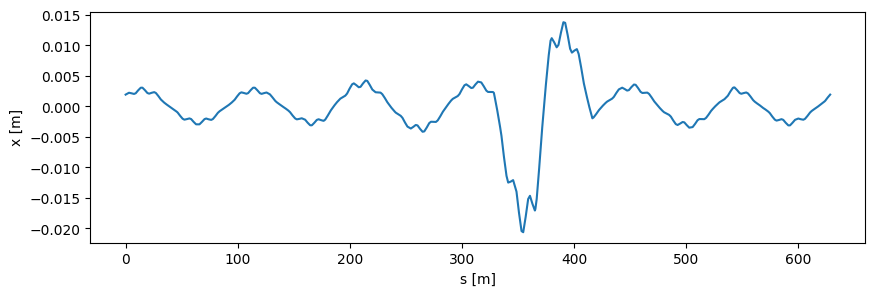

In [8]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(twiss.s, twiss.x)
ax.set_xlabel("s [m]")
ax.set_ylabel("x [m]")

In [9]:
type(twiss)

xtrack.twiss.TwissTable

In [14]:
twiss.keys()

dict_keys(['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'dx_zeta', 'dy_zeta', 'betx1', 'bety1', 'betx2', 'bety2', 'mux', 'muy', 'muzeta', 'nux', 'nuy', 'nuzeta', 'W_matrix', 'dzeta', 'particle_on_co', 'circumference', 'orientation', 'R_matrix', 'qx', 'qy', 'qs', 'slip_factor', 'momentum_compaction_factor', 'betz0', 'T_rev0', 'c_minus', 'c_r1_avg', 'c_r2_avg', 'dmux', 'dmuy', 'dqx', 'dqy', 'values_at', 'method', 'radiation_method', 'reference_frame'])

In [ ]:
twiss_after_makethin.k20l

In [ ]:
twiss_after_makethin.k2

In [23]:
twiss_after_makethin.loc[twiss_after_makethin.k20l != 0 ].k20l

Series([], Name: k20l, dtype: float64)

In [24]:
twiss_after_makethin.loc[twiss_after_makethin.k20sl != 0 ].k20sl

Series([], Name: k20sl, dtype: float64)

In [28]:
twiss_after_makethin.loc[twiss_after_makethin.k2l != 0 ].k2l

pr.xse01.a    0.282794
pr.xse01.b    0.282794
pr.mp01.f    -0.018580
pr.bht01.f    0.014531
pr.mp01.j     0.039348
                ...   
pr.mp00.d    -0.018580
pr.bhr00.d   -0.038142
pr.mp00.j     0.039348
pr.bhr00.f    0.014531
pr.mp00.f    -0.018580
Name: k2l, Length: 503, dtype: float64

In [26]:
twiss_after_makethin.loc[twiss_after_makethin.k2sl != 0 ].k2sl

Series([], Name: k2sl, dtype: float64)

In [44]:
k2l = twiss_after_makethin.loc[twiss_after_makethin.k2l != 0 ].k2l
betx = twiss_after_makethin.loc[twiss_after_makethin.k2l != 0 ].betx
mux = twiss_after_makethin.loc[twiss_after_makethin.k2l != 0 ].mux
mux_rad = twiss_after_makethin.loc[twiss_after_makethin.k2l != 0 ].mux*2*np.pi

S = (1/2)*betx**(3/2)*k2l

In [59]:
S_virtual = np.sqrt(np.sum(S*np.sin(3*mux_rad))**2 + np.sum(S*np.cos(3*mux_rad))**2)
print(f"Virtual Sextupole = {round(S_virtual,6)}")

Virtual Sextupole = 76.603649


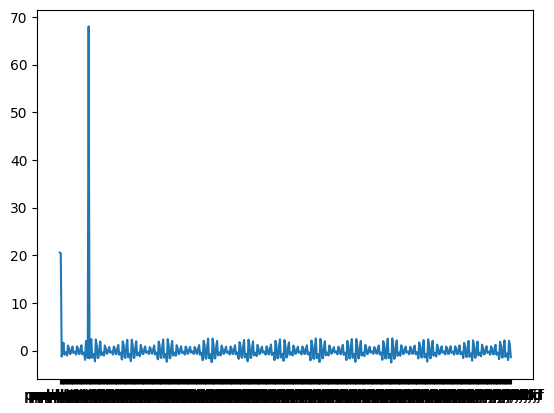

In [61]:
plt.plot(S)

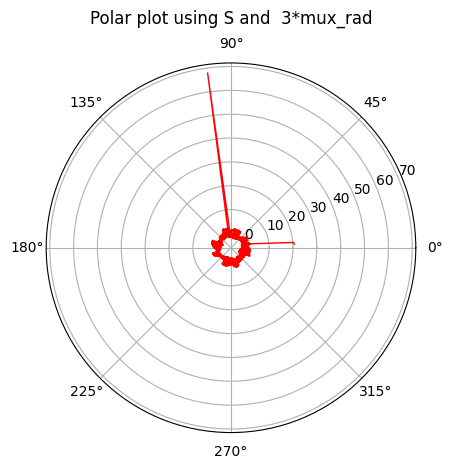

In [69]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111, polar=True)
ax.plot((3*mux_rad) % (2*np.pi), S, color='r', linewidth=1)
ax.set_title("Polar plot using S and  3*mux_rad", va='bottom')
plt.show()


In [73]:
twiss_after_makethin.loc["pe.smh57"].dx

4.291720338203613

In [72]:
twiss_after_makethin.loc["pe.smh57"].dpx

0.0199990888714327